# PyGLImER Tutorial

In this Python notebook we'll describe the first steps to be taken with PyGLImER.
The python API for creating, processing, and imaging a receiver function database.

The main code is hosted here: [PyGLImER](https://github.com/PeterMakus/PyGLImER).

The documentation, which this notebook is based upon is located here:
[PyGLImER Documentation](https://petermakus.github.io/PyGLImER/).

Without further ado, we'll dive right into it starting with data download.

---

## Intro and database setup

In this Tutorial we are going to get all good receiver functions 
for the year 2018 for station IU-HRV ([Adam Dziewonski Observatory](http://www.seismology.harvard.edu/hrv.html)).

To Compute the receiver function we need to download and organize
the observed data.
To take glimpse of how we are structuring the downloaded data,
expand the database tree below.


<details>
<summary> Database tree: </summary>

```
database
|____events
| |____2020-07-04 14:52:05.137534
| |____ ...
| |____2020-07-04 14:11:16.669280
|
|____stations
| |____IU.HRV.xml
|
|____preprocessed
| |____P
|   |____by_event
|   | |____2018172T160800_-24.5_-67.0
|   | | |____IU.HRV.2018172T160800.mseed
|   | |____ ...
|   | |____2018014T091850_-16.0_-74.5
|   | | |____IU.HRV.2018014T091850.mseed
|   | |____2018283T231600_49.5_156.5
|   | | |____IU.HRV.2018283T231600.mseed
|   | |____ ...
|   | |____2018339T064300_-22.0_169.5
|   | |____2018023T230910_-6.0_-12.5        # Seems to keep the empty dirs...
|   |____by_station
|     |____IU
|       |____HRV
|         |____info.db
|         |____IU.HRV.2018021T010640.mseed
|         |____ ...
|         |____IU.HRV.2018236T090410.mseed
|
|____waveforms
| |____P
|   |____2018100T101930_-31.0_-71.5
|   | |____IU.HRV.mseed
|   |____ ...
|   |____2018023T230910_-6.0_-12.5
|     |____IU.HRV.mseed
|
|____RF
| |____P
|   |____IU
|     |____HRV
|       |____IU.HRV.2018224T211500.sac
|       |____ ...
|       |____IU.HRV.2018250T021210.sac
|____RF.log
|____download.log
|____preprocess.log
```
</details>



While it might look a bit intimidating, the structure is fairly simple.
There are 5 main directories: 

1. `events`, containing event data in form of a `QuakeML` catalog.
2. `stations`, containing all station Metadata in form of `StationXML`s.
3. `waveforms`, containing waveform sorted after
    1. Converted phase (`P` or `S`)
    2. Event
    3. `NET.STA.mseed`
4. `preprocessed`, containing cleaned-up RTZ traces. Sorted
    after
    1. Converted phase (`P` or `S`)
    2. `by_event` ...
        1. Event timestamp and location
        2. `NET.STA.mseed`
    2. ... or `by_station`      
        1. Network
        2. Station
        3. `NET.STA.<EVENT_UTC_STAMP>.mseed`
5. `RF`, containing the final Receiver functions.
    1. Converted phase (`P` or `S`)
    2. `NETWORK`
    3. `STATION`
    4. `NET.STA.<EVENT_UTC_STAMP>.sac`
    


***The `by_event` folder does only contain softlinks to the files in `by_station`.***

## Downloading the raw data

To download the data we use the `pyglimer.waveform.request.Request` class.
The first method from this class that we are going to use is the 
download event catalog public method `Request.download_evtcat()`,
to get a set of events that contains all wanted earthquakes.

To initialize said `class` we setup a parameter dictionary, with 
all the needed information. Let's look at the expected information:

In [1]:
import inspect
from pyglimer.waveform.request import Request

# Get expected input arguments
signature = inspect.signature(Request)
print(signature)

# Uncomment for long explanation
# help(Request)

(phase, rot, evtloc, statloc, rawloc, preproloc, rfloc, deconmeth, starttime, endtime, wavdownload=True, pol='v', minmag=5.5, event_coords=None, network=None, station=None, waveform_client=None, re_client=['IRIS'], evtcat=None, debug=False)


So, let's setup a dictionary to handle the input:

In [2]:
import os
from obspy import UTCDateTime

# Get notebook path for future reference of the database:
try: ipynb_path
except NameError: ipynb_path = os.getcwd()
    
# Define file locations
database     = os.path.join(ipynb_path,"database")
event_cat    = os.path.join(database, "events")
station_cat  = os.path.join(database, "stations")
waveform_cat = os.path.join(database, "waveforms")
preproc_cat  = os.path.join(database, "preprocessed")
rf_cat       = os.path.join(database, "RF")

request_dict = {
    # Necessary arguments
    "phase": "P",               # P receiver functions
    "rot": "RTZ",               # Coordinate system to rotate to
    "evtloc": event_cat,        # Directory of the events
    "statloc": station_cat,     # Directory of the stations
    "rawloc": waveform_cat,     # Directory of the waveforms
    "preproloc": preproc_cat,   # Directory of the preprocessed waveforms
    "rfloc": rf_cat,            # Directory of the receiver functions
    "deconmeth": "waterlevel",  # Deconvolution method
    "starttime": UTCDateTime(2018, 1, 1, 0, 0, 0),      # Starttime of database
    "endtime": UTCDateTime(2018, 12, 31, 11, 59, 59),   # Endtimetime of database
    # kwargs below
    "wavdownload": True,         # Download flag 
    "pol": 'v',                  # Source wavelet polaristion. Def. "v" --> SV
    "minmag": 5.5,               # Earthquake minimum magnitude. Def. 5.5
    "event_coords": None,        # Specific event?. Def. None
    "network": "IU",             # Restricts networks. Def. None
    "station": "HRV",            # Restricts stations. Def. None
    "waveform_client": ["IRIS"], # FDSN server client (s. obspy). Def. None
    "re_client": ['IRIS'],       # irrelevant for normal use
    "evtcat": None,              # Use existing `obspy.catalog`
    "debug": False               # False
}

### To P.: This could be loaded as a configuration file via a `yaml` reader. I have one that takes into account UTCdatetimes, so that it loads UTCDatemtime correctly (I think..., might be json as well, doesn't really matter, I'll show you what I mean)

Now that we have all parameters in place, let's inittialize the `Request` `class`

In [5]:
R = Request(**request_dict)

To check whether the data download was successful, 
let's plot the events in the catalog on a map:

In [6]:
from utils.plot_utils import set_mpl_params
from utils.plot_utils import plot_catalog
set_mpl_params()

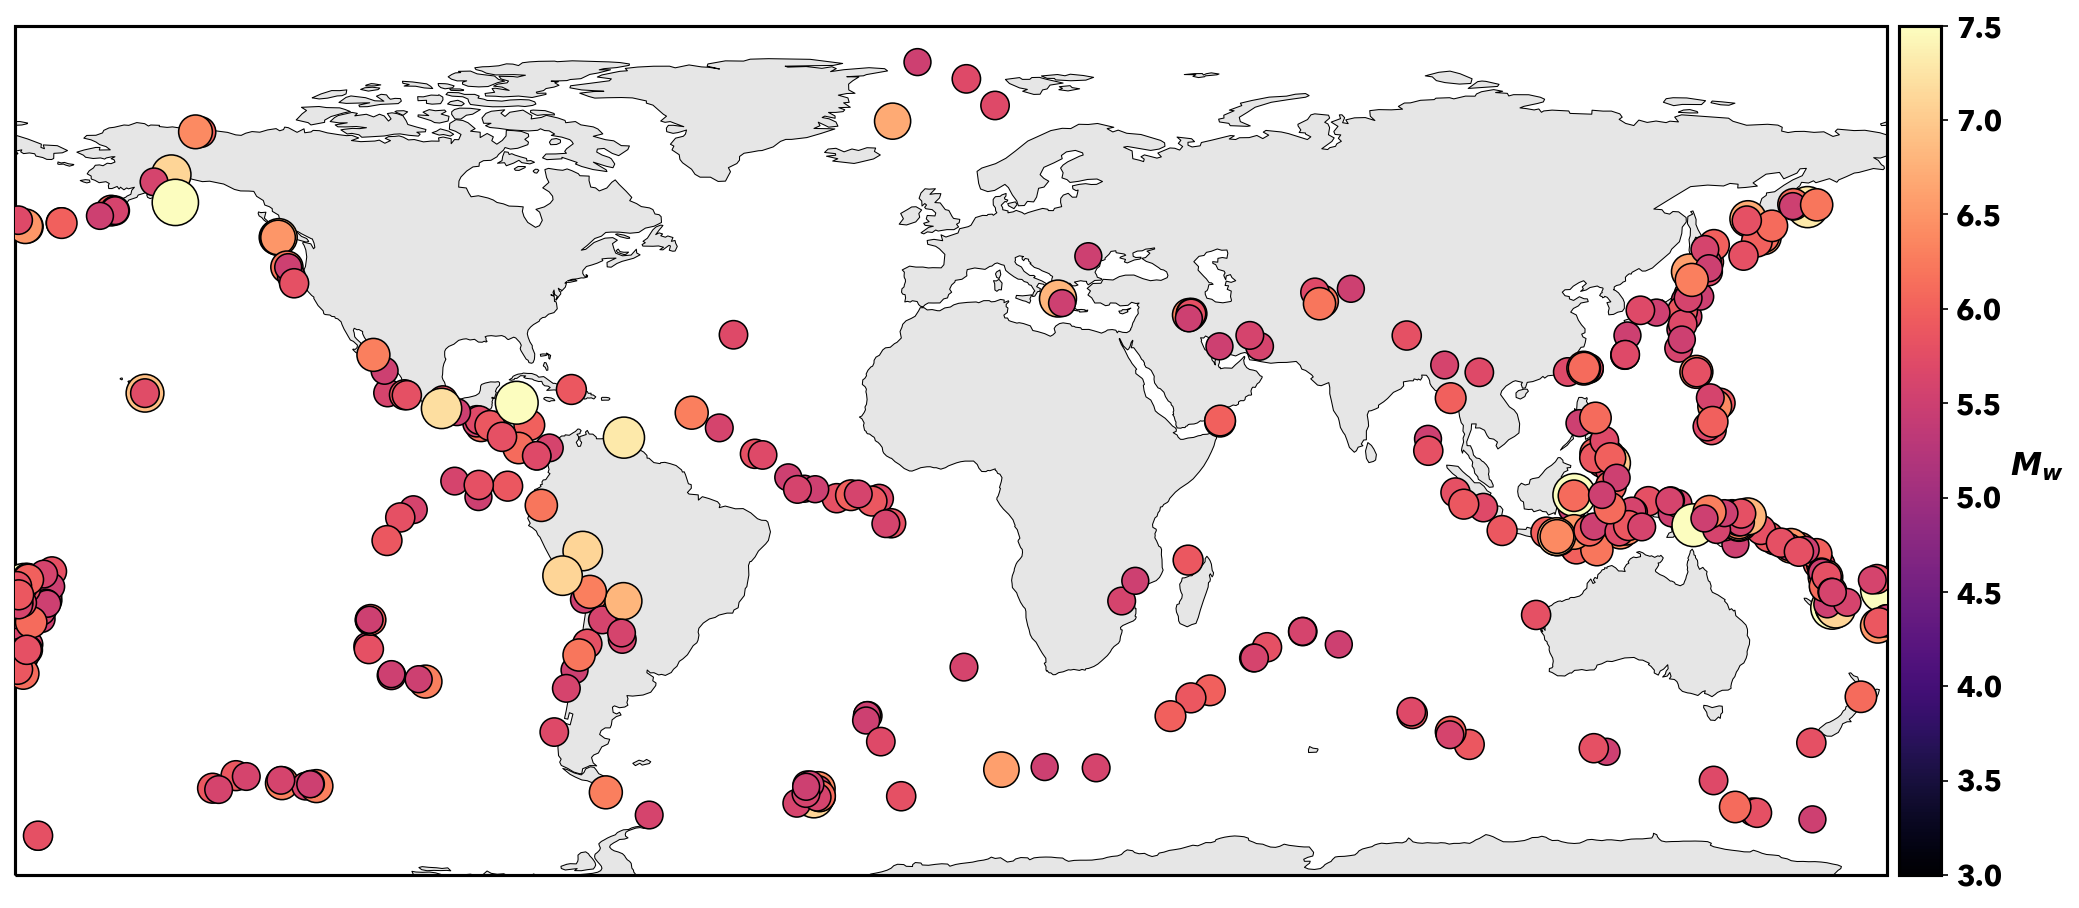

In [5]:
plot_catalog(R.evtcat) 

## Get waveform data

The next step on our journey to receiver functions is retrieving
the corresponding waveform data.
To retrieve the waveform data, we use the `Request`'s
public method, `download_waveforms()`. 
This method uses the station and event locations to get viable
records of receiver function depending on epicentral distance and
traveltimes.

In [6]:
R.download_waveforms()

[2020-07-04 20:03:46,810] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for IRIS.
[2020-07-04 20:03:47,065] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): IRIS.
[2020-07-04 20:03:47,067] - obspy.clients.fdsn.mass_downloader - WARNING: Downloading event: 
[2020-07-04 20:03:47,469] - obspy.clients.fdsn.mass_downloader - WARNING: Downloading event: 
[2020-07-04 20:03:47,618] - obspy.clients.fdsn.mass_downloader - WARNING: Downloading event: 
[2020-07-04 20:03:47,766] - obspy.clients.fdsn.mass_downloader - WARNING: Downloading event: 
[2020-07-04 20:03:47,911] - obspy.clients.fdsn.mass_downloader - WARNING: Downloading event: 
[2020-07-04 20:03:48,059] - obspy.clients.fdsn.mass_downloader - WARNING: Downloading event: 
[2020-07-04 20:03:48,432] - obspy.clients.fdsn.mass_downloader - WARNING: Downloading event: 
[2020-07-04 20:03:48,578] - obspy.clients.fdsn.mass_downloader - WARNING: Downloading event: 
[2020-07-04 20:03:48,724

Should the download be successful, we can check the number of waveforms donwloaded with a bash oneliner

In [7]:
print("Number of downloaded waveforms:")
!ls database/waveforms/**/*.mseed | wc -l

Number of downloaded waveforms:
ls: cannot access 'database/waveforms/**/*.mseed': No such file or directory
0


This means that we can get 

## Preprocessing

Now, that we have all the waveform data in place.
We can perform the first preprocessing. This part includes:

1. Clips waveform to the right length
   (tz before and ta after theorethical arrival.)
2. Demean & Detrend
3. Tapering
4. Remove Instrument response, convert to velocity &
   simulate havard station
5. Rotation to NEZ and, subsequently, to RTZ.
6. Compute SNR for highpass filtered waveforms
   (highpass f defined in qc.lowco)
   If SNR lower than in qc.SNR_criteria for all filters,
   rejects waveform.
7. Write finished and filtered waveforms to folder
   specified in qc.outputloc.
8. Write info file with shelf containing station,
   event and waveform information.
9. (Optional) If we had chosen a different coordinate system in ``rot``
   than RTZ, it would now cast the preprocessed waveforms information
   that very coordinate system.
10.Deconvolution with method ``deconmeth`` from our dict is perfomed.
   
It again uses the request class to perform this.


In [8]:
setattr(R, 'pol', 'v')
R.preprocess()

Download and preprocessing finished.


# First RF Plots

The following few section show how to plot 

1. Single raw RFs
2. A set of raw RFs
3. A move-out corrected RF
4. A set of move-out corrected RFs


## Read the IU-HRV receiver functions as a Receiver function stream



In [9]:
from utils.plot_utils import set_mpl_params
from pyglimer.rf.create import read_rf
set_mpl_params()

rfst = read_rf("database/RF/P/IU/HRV/*.sac")

## Plot the raw RFs

If the Receiver functions haven't been further processed,
they are plotted as a function of time. A single receiver
function in the stream will be plotted as function of time
only

(<Figure size 900x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa3969656d0>)

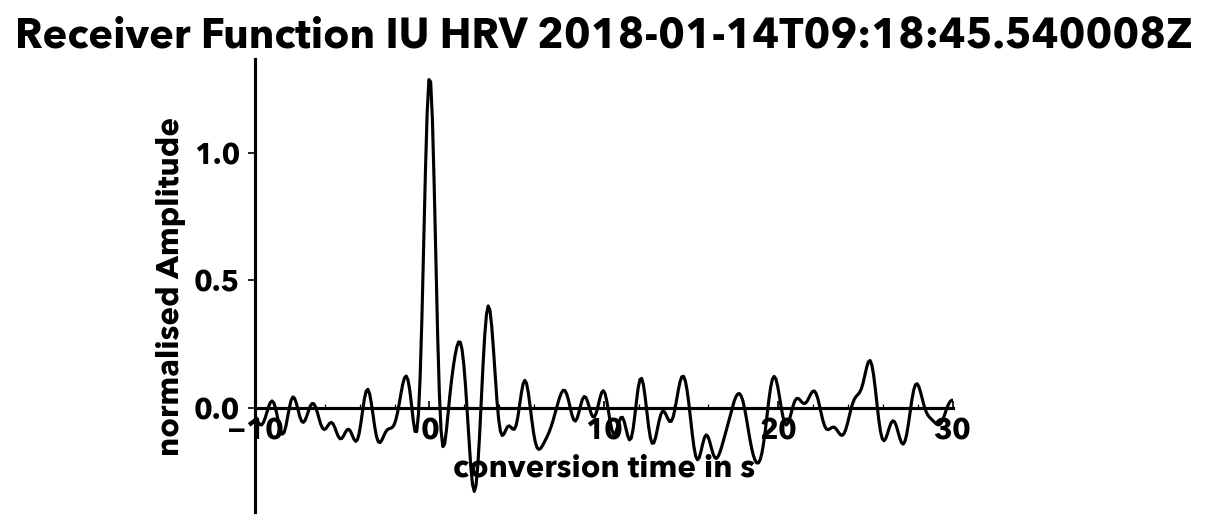

In [10]:
rfst[0].plot()


A set will be plotted as a function of epicentral distance.

(<Figure size 1000x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa396894e80>)

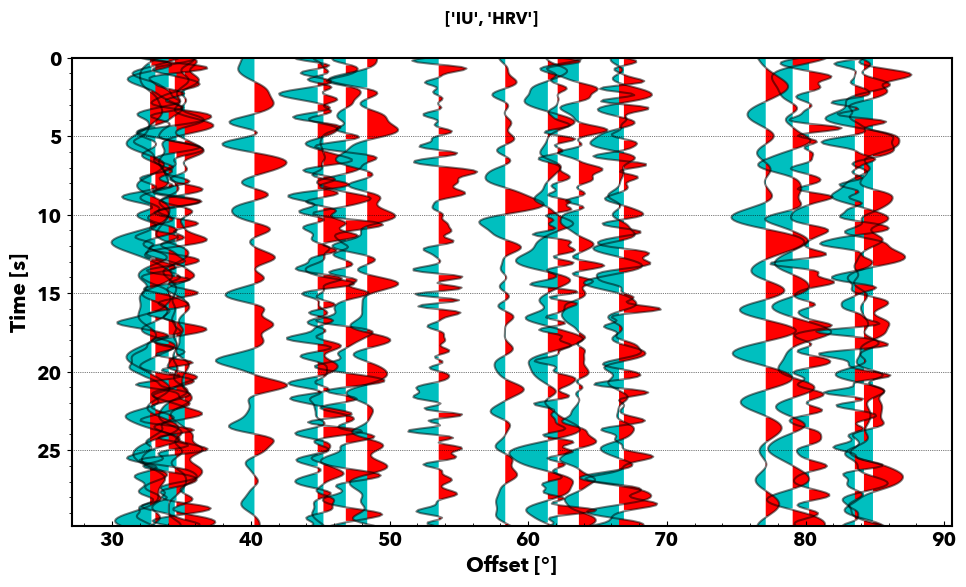

In [11]:
rfst.plot()

In [12]:
# rfst.moveout()